# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [135]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def sigmoid(self, z: np.array) -> np.array:
        """Вычисление сигмоидальной функции."""
        return 1 / (1 + np.exp(-z))


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        # your code
        n_samples, d = X.shape
        
        if self.w0 is None:
            self.w = np.zeros(d)  # инициализируем веса
        else:
            self.w = self.w0.copy()

        # Градиентный спуск
        w_prev = self.w.copy()
        for _ in range(self.max_iter):
            match self.gd_type:
                case 'full':
                    grad = self.calc_gradient(X, y)
                case 'stochastic':
                    i = np.random.randint(0, n_samples)
                    grad = self.calc_gradient(X[i:i + 1], y[i:i + 1])
                case _:
                    raise ValueError("gd_type must be 'full' or 'stochastic'")
                
            self.w -= self.eta * grad
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                break
            w_prev = self.w.copy()
        
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        z = X @ self.w
        probs = self.sigmoid(z)
        # Возвращаем как для положительного, так и для отрицательного классов
        return np.column_stack((1 - probs, probs))

        
    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        n = X.shape[0]
        z = X @ self.w
        prob = self.sigmoid(z)
        grad = X.T @ (prob - y) / n
        return grad


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        z = X @ self.w

        h = self.sigmoid(z)
        h = np.clip(h, 1e-15, 1 - 1e-15)

        # Вычисляем logloss
        loss = -np.mean(
            (  y  ) * np.log(h) + 
            (1 - y) * np.log(1 - h)
        )
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [136]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

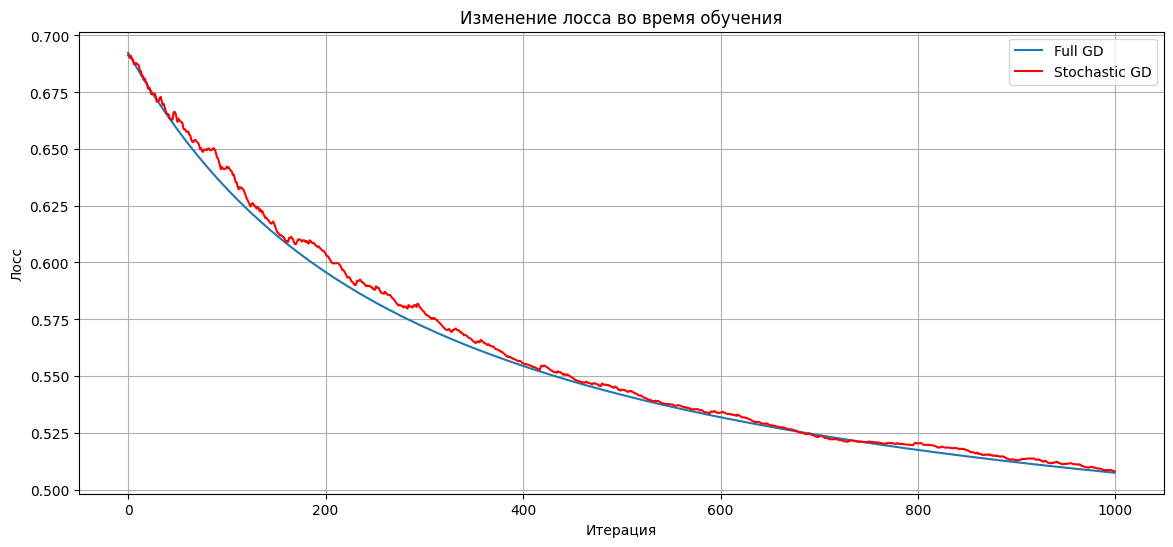

In [137]:
# your code
# Полный градиентный спуск
model_full = MyLogisticRegression(gd_type='full', 
                                  tolerance=1e-6, 
                                  max_iter=1000, 
                                  eta=1e-3)
model_full.fit(X_train, y_train)

# Стохастический градиентный спуск
model_stochastic = MyLogisticRegression(gd_type='stochastic', 
                                        tolerance=1e-6, 
                                        max_iter=1000, 
                                        eta=1e-3)
model_stochastic.fit(X_train, y_train)


plt.figure(figsize=(14, 6))
plt.plot(model_full.loss_history, label='Full GD')
plt.plot(model_stochastic.loss_history, 'r', label='Stochastic GD')
plt.xlabel('Итерация')
plt.ylabel('Лосс')
plt.title('Изменение лосса во время обучения')
plt.legend()
plt.grid(True)
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

ROC-AUC | Full GD: 0.8442  Stochastic GD: 0.8432
PR-AUC | Full GD: 0.7948  Stochastic GD: 0.7917


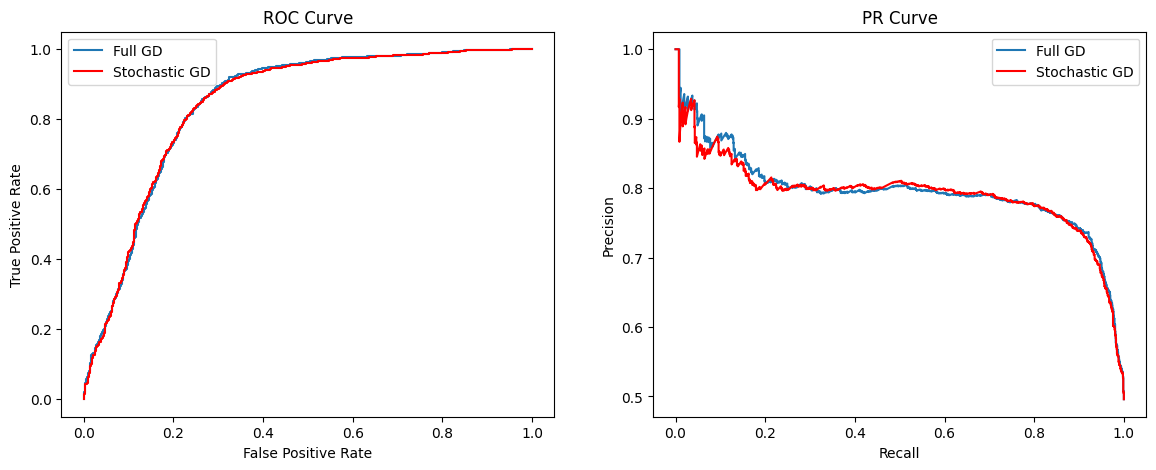

In [138]:
# your code
# Предсказываем вероятности на тестовой выборке
probs_full = model_full.predict_proba(X_test)[:, 1]
probs_stochastic = model_stochastic.predict_proba(X_test)[:, 1]


# Высчитываем ROC-AUC и PR-AUC
roc_auc_full = roc_auc_score(y_test, probs_full)
roc_auc_stochastic = roc_auc_score(y_test, probs_stochastic)

precision_full, recall_full, _ = precision_recall_curve(y_test, probs_full)
pr_auc_full = auc(recall_full, precision_full)

precision_stochastic, recall_stochastic, _ = precision_recall_curve(y_test, probs_stochastic)
pr_auc_stochastic = auc(recall_stochastic, precision_stochastic)

fpr_full, tpr_full, _ = roc_curve(y_test, probs_full)
fpr_stochastic, tpr_stochastic, _ = roc_curve(y_test, probs_stochastic)

print(f'ROC-AUC | Full GD: {roc_auc_full:.4f}  Stochastic GD: {roc_auc_stochastic:.4f}')
print(f'PR-AUC | Full GD: {pr_auc_full:.4f}  Stochastic GD: {pr_auc_stochastic:.4f}')


# Визуализируем ROC- и PR- кривые
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_full, tpr_full, label='Full GD')
plt.plot(fpr_stochastic, tpr_stochastic, 'r', label='Stochastic GD')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_full, precision_full, label='Full GD')
plt.plot(recall_stochastic, precision_stochastic, 'r', label='Stochastic GD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend()

plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [139]:
# your code
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state=42)

roc_auc_scores = []
pr_auc_scores = []

for train_idx, val_idx in kfold.split(X, y):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Обучаем модель
    model = MyLogisticRegression(gd_type='full', 
                                 eta=0.1, 
                                 max_iter=1000, 
                                 tolerance=1e-6)
    model.fit(X_train_cv, y_train_cv)

    # Предсказываем вероятности
    probs = model.predict_proba(X_val_cv)[:, 1]

    # Вычисляем метрики ROC-AUC и PR-AUC
    roc_auc_scores.append(roc_auc_score(y_val_cv, probs))
    pr, re, _ = precision_recall_curve(y_val_cv, probs)
    pr_auc_scores.append(auc(re, pr))


print('Оценка ошибки с помощью KFold cross-validation:')
print(f'ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}')
print(f'PR-AUC:  {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}')

Оценка ошибки с помощью KFold cross-validation:
ROC-AUC: 0.8611 ± 0.0099
PR-AUC:  0.8318 ± 0.0144


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [189]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [190]:
# `load_boston` has been removed from scikit-learn since version 1.2.

# from sklearn.datasets import load_boston
# boston = load_boston()

In [191]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
# data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [336]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [337]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [338]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [339]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержит целевую переменную.
    """
    # your code
    y = R[R.dtype.names[-1]]  # получаем таргет
    unique, counts = np.unique(y, return_counts=True)  # уникальные классы и их размер
    p = counts / len(y)  # пропорции каждого класса
    
    gini = 1 - np.sum(p**2)  # gini impurity
    return gini


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code
    left = R_m[R_m[feature] <= t]  # объекты левее, либо равные порогу
    right = R_m[R_m[feature] > t]  # объекты правее порога
    return left, right


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code
    # Разделяем вершину на подмножества
    left, right = split_node(R_m, feature, t)
    # Вычисляем критерий ошибки (взвешенная сумма информативностей)
    q = (len(left) / len(R_m)) * H(left) + (len(right) / len(R_m)) * H(right)
    return q

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

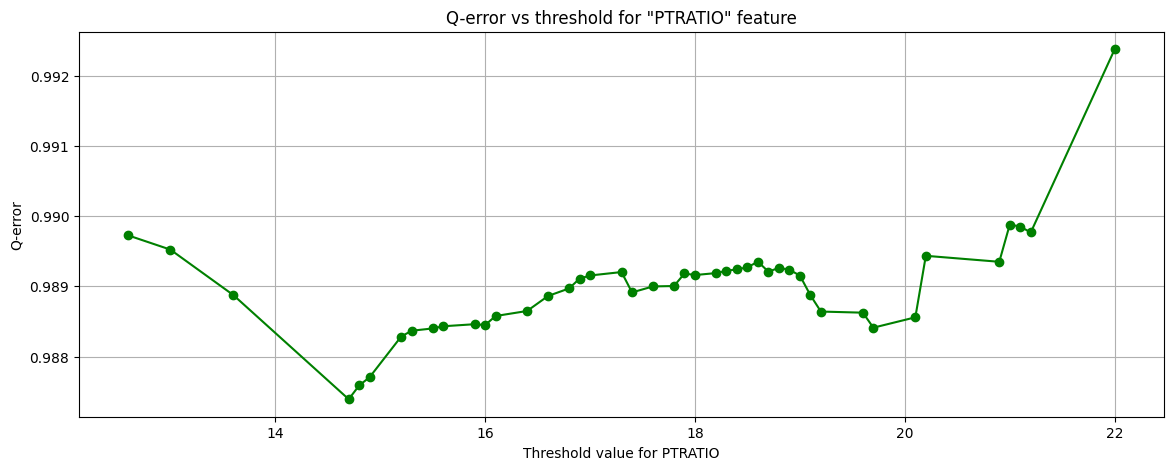

In [340]:
# your code
feature = 'PTRATIO'

R_m = X_train.to_records(index=False)
thresholds = np.unique(X_train[feature])

q_errors = [
    q_error(R_m, feature, t) for t in thresholds
]


# Визуализируем
plt.figure(figsize=(14, 5))
plt.plot(thresholds, q_errors, marker='o', linestyle='-', color='g')
plt.xlabel(f'Threshold value for {feature}')
plt.ylabel('Q-error')
plt.title(f'Q-error vs threshold for "{feature}" feature')
plt.grid(True)
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [341]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code
    thresholds = np.unique(R_m[feature])  # пороги для признака
    q_errors = [q_error(R_m, feature, t) for t in thresholds]
    best_t = thresholds[np.argmin(q_errors)]
    return best_t, q_errors

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Best feature: CRIM
Best threshold: 15.5757
Min Q-error: 0.985


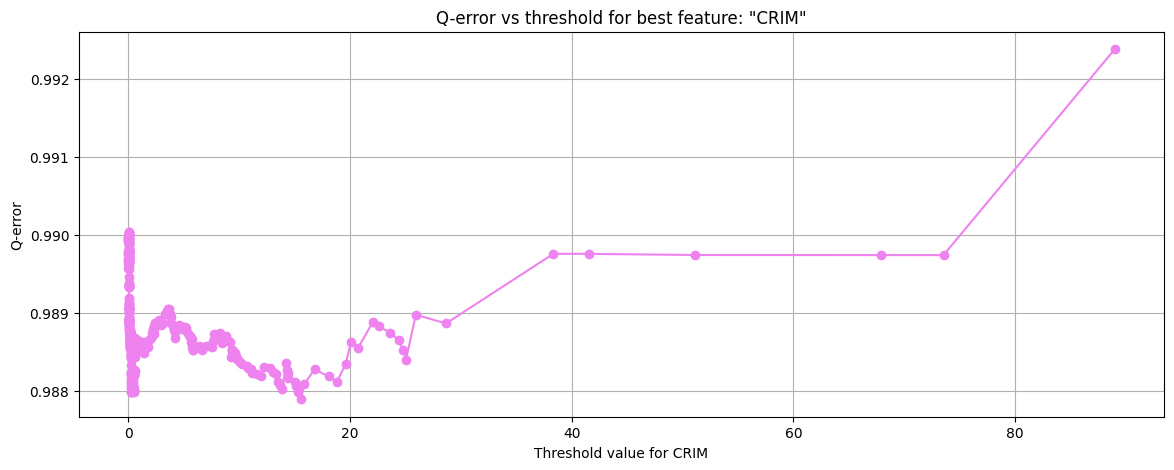

In [342]:
best_feature = None
best_t = None
best_q = float('inf')

q_errors_dict = {}

for feature in R_m.dtype.names[:-1]:
    t, q_errors = get_optimal_split(R_m, feature)
    min_q = min(qs)
    if min_q < best_q:
        best_q = min_q
        best_feature = feature
        best_t = t
    q_errors_dict[feature] = q_errors

print(f'Best feature: {best_feature}')
print(f'Best threshold: {best_t}')
print(f'Min Q-error: {best_q:.3f}')


# Визуализируем
thresholds = np.unique(R_m[best_feature])
q_errors = [q_error(R_m, feature, t) for t in thresholds]

plt.figure(figsize=(14, 5))
plt.plot(thresholds, q_errors_dict[best_feature], marker='o', linestyle='-', color='violet')
plt.xlabel(f'Threshold value for {best_feature}')
plt.ylabel('Q-error')
plt.title(f'Q-error vs threshold for best feature: "{best_feature}"')
plt.grid(True)
plt.show()

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

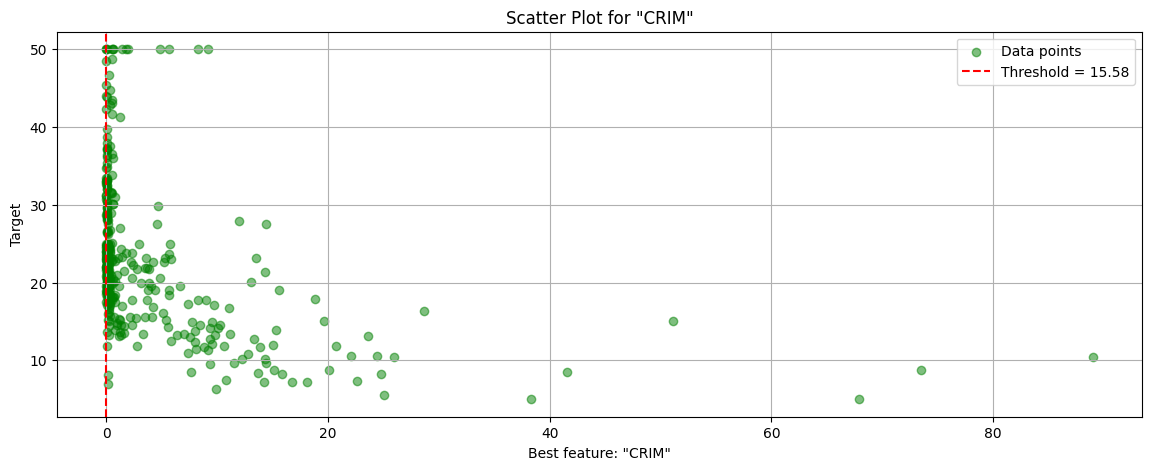

In [343]:
# your code
plt.figure(figsize=(14, 5))

plt.scatter(X_train[best_feature], X_train['target'], color='g', alpha=0.5, label='Data points')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Threshold = {best_t:.2f}")
plt.xlabel(f'Best feature: "{best_feature}"')
plt.ylabel(f'Target')
plt.title(f'Scatter Plot for "{best_feature}"')
plt.legend()
plt.grid(True)
plt.show()